# LR Distance Cross-identification

In this notebook we take a logistic regression classifier and swap its distance feature out, comparing the result to multiplying probabilities by a Gaussian.

We'll then try optimising over $\sigma$.

In [5]:
import sys
sys.path.insert(1, '/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/scripts')
import pipeline
import h5py, astropy.io.ascii as asc
import numpy
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

swire_names_cdfs, swire_coords_cdfs, swire_features_cdfs = pipeline.generate_swire_features(field='cdfs')
swire_names_elais, swire_coords_elais, swire_features_elais = pipeline.generate_swire_features(field='elais')
swire_labels_cdfs = pipeline.generate_swire_labels(swire_names_cdfs, swire_coords_cdfs, field='cdfs')
swire_labels_elais = pipeline.generate_swire_labels(swire_names_elais, swire_coords_elais, field='elais')
(atlas_train_sets_cdfs, atlas_test_sets_cdfs), (swire_train_sets_cdfs, swire_test_sets_cdfs) = pipeline.generate_data_sets(swire_coords_cdfs, swire_labels_cdfs, field='cdfs')
(atlas_train_sets_elais, atlas_test_sets_elais), (swire_train_sets_elais, swire_test_sets_elais) = pipeline.generate_data_sets(swire_coords_elais, swire_labels_elais, field='elais')
table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')

In [2]:
import scipy.spatial

swire_tree = scipy.spatial.KDTree(swire_coords_cdfs)

In [3]:
swire_name_to_index = {j:i for i, j in enumerate(swire_names_cdfs)}

In [29]:
# Distances are normalised and centred. We need to figure out what by.
n_swire = len(swire_features_cdfs)
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5', 'r') as crowdastro_f:
    distances = crowdastro_f['/atlas/cdfs/numeric'][:, -n_swire:].min(axis=0)
mean_dist = distances.mean()
distances -= distances.mean()
stdev_dist = distances.std()

In [30]:
import sklearn.ensemble, random, crowdastro.crowd.util, numpy, sklearn.metrics, astropy.coordinates

for quadrant in range(4):
    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced',
                                                 C=100000.0)
    # Train a classifier.
    train = swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0]
    train_features = swire_features_cdfs[train]
    train_labels = swire_labels_cdfs[train, 0]
    test_features = swire_features_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant]]
    test_labels = swire_labels_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant], 0]
    lr.fit(train_features, train_labels)

    # Test on the cross-identification task.
    n_total = 0
    n_correct_regular = 0
    n_correct_dist = 0
    n_correct_gaussian = 0
    for atlas in atlas_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0]:
        row = table[table['Key'] == atlas][0]
        ra = row['Component RA (Franzen)']
        dec = row['Component DEC (Franzen)']
        swire = row['Source SWIRE (Norris)']
        if not swire.startswith('SWIRE'):
            continue
        nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
        nearby_features = swire_features_cdfs[nearby]
        if not nearby:
            continue
        atpreds = lr.predict_proba(nearby_features)[:, 1]
        names = [swire_names_cdfs[n] for n in nearby]
        
        # Coordinate setup
        coord_atlas = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit='deg')
        coords_swire = astropy.coordinates.SkyCoord(ra=swire_coords_cdfs[nearby, 0],
                                                    dec=swire_coords_cdfs[nearby, 1],
                                                    unit='deg')
        separations = numpy.array(coord_atlas.separation(coords_swire).deg)
        
        # Regular
        name = names[numpy.argmax(atpreds)]
        n_correct_regular += name == swire
        
        # Gaussian multiplier
        gaussians = scipy.stats.norm.pdf(separations, scale=1 / 120)
        gaussian_preds = atpreds * gaussians
        name = names[numpy.argmax(gaussian_preds)]
        n_correct_gaussian += name == swire
        
        # Distance substitute
        # We actually need to recompute the predictions for this.
        modified_features = nearby_features.copy()
        # The 10th feature is distance. Replace this by the normalised and centred separations.
        normalised_separations = separations - mean_dist
        normalised_separations /= stdev_dist
        modified_features[:, 9] = normalised_separations
        dist_preds = lr.predict_proba(modified_features)[:, 1]
        name = names[numpy.argmax(dist_preds)]
        n_correct_dist += name == swire
        
        n_total += 1
    print('Regular:', n_correct_regular / n_total)
    print('Gaussian:', n_correct_gaussian / n_total)
    print('Distance:', n_correct_dist / n_total)

Regular: 0.8120805369127517
Gaussian: 0.9328859060402684
Distance: 0.8993288590604027
Regular: 0.825
Gaussian: 0.9416666666666667
Distance: 0.9166666666666666
Regular: 0.8470588235294118
Gaussian: 0.9294117647058824
Distance: 0.9176470588235294
Regular: 0.831858407079646
Gaussian: 0.9380530973451328
Distance: 0.911504424778761


It seems that Gaussian does very well. Now, let's optimise over $\sigma$. We'll do this four times, once for each quadrant, to avoid biasing our tests.

In [ ]:
# Cache the parts of the calculation that never change.
_lrs = {}
_atres = {i:{} for i in range(4)}

In [99]:
def xid_acc(sigma, quadrant):
    if quadrant in _lrs:
        lr = _lrs[quadrant]
    else:
        lr = sklearn.linear_model.LogisticRegression(class_weight='balanced',
                                                     C=100000.0)
        # Train a classifier.
        train = swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0]
        train_features = swire_features_cdfs[train]
        train_labels = swire_labels_cdfs[train, 0]
        test_features = swire_features_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant]]
        test_labels = swire_labels_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant], 0]
        lr.fit(train_features, train_labels)
        
        _lrs[quadrant] = lr

    # Test on the cross-identification task
    # Note that we want to test on the *training* set
    # so our parameters aren't influenced by the test data.
    n_total = 0
    n_correct_gaussian = 0
    for atlas in atlas_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0]:
        if atlas in _atres[quadrant]:
            atpreds, names, separations, swire = _atres[quadrant][atlas]
        else:
            row = table[table['Key'] == atlas][0]
            ra = row['Component RA (Franzen)']
            dec = row['Component DEC (Franzen)']
            swire = row['Source SWIRE (Norris)']
            if not swire.startswith('SWIRE'):
                continue
            nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
            nearby_features = swire_features_cdfs[nearby]
            if not nearby:
                continue
            atpreds = lr.predict_proba(nearby_features)[:, 1]
            names = [swire_names_cdfs[n] for n in nearby]

            # Coordinate setup
            coord_atlas = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit='deg')
            coords_swire = astropy.coordinates.SkyCoord(ra=swire_coords_cdfs[nearby, 0],
                                                        dec=swire_coords_cdfs[nearby, 1],
                                                        unit='deg')
            separations = numpy.array(coord_atlas.separation(coords_swire).deg)
            _atres[quadrant][atlas] = (atpreds, names, separations, swire)
        
        # Gaussian multiplier
        gaussians = scipy.stats.norm.pdf(separations, scale=sigma)
        gaussian_preds = atpreds * gaussians
        name = names[numpy.argmax(gaussian_preds)]
        n_correct_gaussian += name == swire
        n_total += 1

    print(sigma, n_correct_gaussian / n_total)
    return n_correct_gaussian / n_total

Let's use `hyperopt` to optimise $\sigma$. For our prior we'll assume a normal distribution around $\sigma = 1 / 120$.

In [95]:
import hyperopt

In [151]:
trials = {}
for q in range(4):
    trials[q] = hyperopt.Trials()

In [152]:
space = hyperopt.hp.uniform('sigma', 1 / 1000, 1 / 50)

In [153]:
bests = {}
for q in range(4):
    bests[q] = hyperopt.fmin(lambda s: -xid_acc(s, q),
        space=space,
        algo=hyperopt.tpe.suggest,
        max_evals=200,
        trials=trials[q])

0.0032560455353812133 0.9465408805031447
0.00802427395284987 0.9528301886792453
0.011449169234809549 0.9528301886792453
0.013572476092415141 0.9528301886792453
0.013320256747748473 0.9528301886792453
0.009080952833436493 0.949685534591195
0.012932613501220887 0.9528301886792453
0.007021578154404058 0.9528301886792453
0.01832359263706058 0.949685534591195
0.01145002976294927 0.9528301886792453
0.014691091845114555 0.9528301886792453
0.018973971948165514 0.9465408805031447
0.016561639532630786 0.9528301886792453
0.0155058970415024 0.9528301886792453
0.017477301130701027 0.949685534591195
0.01048002656199359 0.949685534591195
0.018609612458078285 0.949685534591195
0.019158751608702302 0.9465408805031447
0.001888829553586474 0.9465408805031447
0.0177755490030734 0.949685534591195
0.00605119663103571 0.9528301886792453
0.015599377307338411 0.9528301886792453
0.015881406498872652 0.9528301886792453
0.014780978888760949 0.9528301886792453
0.019826781913630166 0.9465408805031447
0.016759096576

0.006300711309287365 0.9596541786743515
0.01141918447580128 0.9567723342939481
0.016331438616910943 0.9538904899135446
0.003396351587790316 0.9538904899135446
0.01289734402989411 0.9567723342939481
0.0037036432909113314 0.9567723342939481
0.005853329398137479 0.9596541786743515
0.013379688629018272 0.9567723342939481
0.018828687484159112 0.9452449567723343
0.014317793640197488 0.9538904899135446
0.013094153215735607 0.9567723342939481
0.013129704125948799 0.9567723342939481
0.017056398276983045 0.9538904899135446
0.009053517856104736 0.9596541786743515
0.009458349451172417 0.9596541786743515
0.009930104057810677 0.9596541786743515
0.008020468556045407 0.9596541786743515
0.00794380998715074 0.9596541786743515
0.0011578661945193603 0.9423631123919308
0.010555671557212664 0.9567723342939481
0.005801794322205288 0.9596541786743515
0.005512797057199179 0.9567723342939481
0.007708729683292642 0.9596541786743515
0.004827404260683952 0.9567723342939481
0.002085433967768841 0.9481268011527377
0

0.014788141205565118 0.9554973821989529
0.012183121484951938 0.9581151832460733
0.006896436212720844 0.9607329842931938
0.01558835202380823 0.9554973821989529
0.014477249158986207 0.9554973821989529
0.0023552501416366275 0.9502617801047121
0.01047729855615058 0.9607329842931938
0.013486102566141741 0.9554973821989529
0.019743666909279443 0.9476439790575916
0.007037410239448137 0.9581151832460733
0.0036050140464785963 0.9528795811518325
0.010089382139696432 0.9607329842931938
0.010467661453546303 0.9607329842931938
0.019010318826910493 0.9476439790575916
0.008332023166229555 0.9607329842931938
0.007861080479831917 0.9581151832460733
0.0174642480651992 0.9502617801047121
0.005334883304645082 0.9581151832460733
0.003062358987696627 0.9528795811518325
0.005142397252714126 0.9581151832460733
0.009556269913953601 0.9607329842931938
0.01124606652118756 0.9607329842931938
0.011788536578410527 0.9607329842931938
0.013742809604874947 0.9554973821989529
0.001114119056342188 0.9450261780104712
0.0

0.005744618963188624 0.9576271186440678
0.013258756376054899 0.9548022598870056
0.0017134177369534777 0.9491525423728814
0.0014927507625236715 0.9491525423728814
0.011109370700764749 0.96045197740113
0.01283653481450592 0.9548022598870056
0.016362983181606155 0.9519774011299436
0.013851473675774858 0.9548022598870056
0.018174382413427163 0.9519774011299436
0.0026856935653908776 0.96045197740113
0.009627540667426515 0.96045197740113
0.014743875124049611 0.9548022598870056
0.011429201530557714 0.96045197740113
0.011989867551838469 0.96045197740113
0.009841472386951017 0.96045197740113
0.017612229525509494 0.9519774011299436
0.003446629205319453 0.9576271186440678
0.008026779935050526 0.96045197740113
0.005191601824285862 0.9519774011299436
0.015088279181619358 0.9548022598870056
0.006981719155338519 0.96045197740113
0.010034200997630954 0.96045197740113
0.0023320704866758406 0.9576271186440678
0.003497066294348666 0.9576271186440678
0.00866487240851582 0.96045197740113
0.0071912731519873

In [154]:
[1 / bests[q]['sigma'] for q in range(4)]

[124.6218668350479, 103.66107258412467, 118.63862355647069, 95.42590903718711]

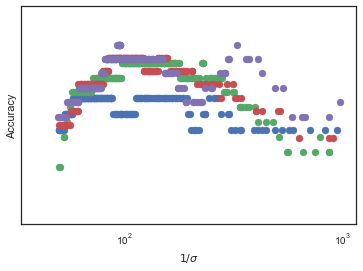

In [156]:
plt.xlabel('$1/\\sigma$')
plt.ylabel('Accuracy')
for q in range(4):
    plt.scatter(1 / numpy.array(trials[q].vals['sigma']), [-r['loss'] for r in trials[q].results])
plt.yscale('log')
plt.xscale('log')